In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import time
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

####  Prepare observations

In [2]:
@tf.function
def epileptor2D_ode_fn(t, y, x0, tau, K, SC):
    nn = tf.math.floordiv(y.shape[0], 2)
    x = y[0:nn]
    z = y[nn:2*nn]
    I1 = tf.constant(4.1, dtype=tf.float32)
    dx = 1.0 - tf.math.pow(x, 3) - 2 * tf.math.pow(x, 2) - z + I1
    gx = tf.reduce_sum(K * SC * (x[tf.newaxis, :] - x[:, tf.newaxis]), axis=1)
    dz = (1.0/tau)*(4*(x - x0) - z - gx)
    return tf.concat((dx, dz), axis=0)

In [3]:
tvb_syn_data = np.load("datasets/syn_data/id001_bt/syn_tvb_ez=48-79_pz=11-17-22-75.npz")
SC = np.load(f'datasets/syn_data/id001_bt/network.npz')['SC']
K_true = tf.constant(np.max(SC), dtype=tf.float32)
SC = SC / K_true.numpy()
SC[np.diag_indices(SC.shape[0])] = 0
SC = tf.constant(SC, dtype=tf.float32)
nn = SC.shape[0]
x_init_true = tf.constant(-2.0, dtype=tf.float32) * tf.ones(nn, dtype=tf.float32)
z_init_true = tf.constant(5.0, dtype=tf.float32) * tf.ones(nn, dtype=tf.float32)
y_init_true = tf.concat((x_init_true, z_init_true), axis=0)
tau_true = tf.constant(25, dtype=tf.float32)
x0_true = tf.constant(tvb_syn_data['x0'], dtype=tf.float32)
t_init = tf.constant(0.0, dtype=tf.float32)
time_step = tf.constant(0.1, dtype=tf.float32)
solution_times = time_step * tf.range(0, 300, dtype=tf.float32)

In [4]:
@tf.function
def integrator(ode_fn, t_init, y_init, solution_times, constants):
    return tfp.math.ode.BDF(rtol=1e-6).solve(ode_fn=ode_fn,
                             initial_time=t_init,
                             initial_state=y_init,
                             solution_times=solution_times,
                             constants=constants)

start_time = time.time()
y_true = integrator(epileptor2D_ode_fn, t_init, y_init_true, solution_times, {'x0':x0_true, 'tau':tau_true, 'K':K_true, 'SC':SC})
print(f'Simulation took {time.time()-start_time} seconds')
obs_data = dict()
obs_data['x'] = y_true.states[:,0:nn] + tfd.Normal(loc=0, scale=0.1).sample((y_true.states.shape[0], nn))
obs_data['z'] = y_true.states[:,nn:2*nn]

Simulation took 46.93518328666687 seconds


In [5]:
print(tf.autograph.to_code(integrator.python_function))

def tf__integrator(ode_fn, t_init, y_init, solution_times, constants):
    with ag__.FunctionScope('integrator', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        try:
            do_return = True
            retval_ = ag__.converted_call(ag__.converted_call(ag__.ld(tfp).math.ode.BDF, (), None, fscope).solve, (), dict(ode_fn=ag__.ld(Epileptor2D_ode_fn), initial_time=ag__.ld(t_init), initial_state=ag__.ld(y_init), solution_times=ag__.ld(solution_times), constants=ag__.ld(constants)), fscope)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



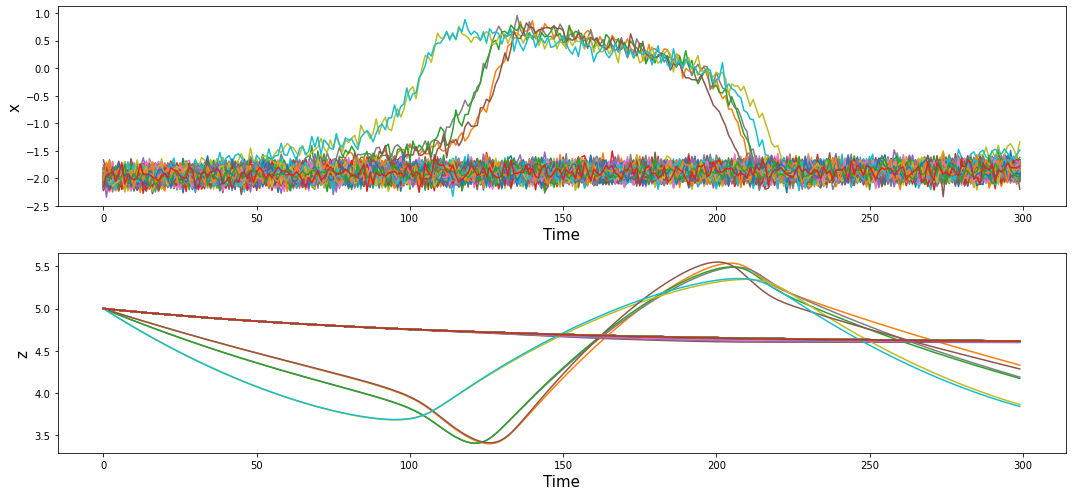

In [5]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(obs_data['x'])
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)

plt.subplot(2,1,2)
plt.plot(obs_data['z'])
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.tight_layout()

# plt.figure()
# plt.title("Phase space plot", fontsize=15)
# plt.plot(obs_data['x'], obs_data['z'])
# plt.xlabel('x', fontsize=15)
# plt.ylabel('z', fontsize=15)


## Define Generative Model

In [6]:
# class GM_Epileptor2D():

#     def __init__(self, theta, obs_data):
#         self.obs_data = obs_data
#         self.params = dict()
#         self.params['x0'] = theta[0]
#         self.params['tau'] = theta[1]
#         self.y_init = tf.constant([-2.0, 5.0])
#         self.dt = tf.constant(0.1)
#         self.solution_times = self.dt * np.arange(0, 300)
#         self.eps = tf.constant(0.1)

    
#     def update_params(self, theta):
#         self.params['x0'] = theta[0]
#         self.params['tau'] = tf.constant(10.0, dtype=tf.float32) + tf.math.exp(theta[1])
    
#     def log_prob(self, theta):
#         self.update_params(theta)
#         return self.likelihood() + self.prior()

#     def likelihood(self):
#         y_pred = tfp.math.ode.BDF().solve(ode_fn=Epileptor2D_ode_fn,
#                              initial_time=0.0,
#                              initial_state=self.y_init,
#                              solution_times=self.solution_times,
#                              constants=self.params)
#         x_mu = y_pred.states[:,0]
#         # print(x_mu, self.eps, self.obs_data['x'])
#         return tf.reduce_sum(tfd.Normal(loc=x_mu, scale=self.eps).log_prob(self.obs_data['x']))
    
#     def prior(self):
#         prior_prob = 0.0
#         prior_prob += tfd.Normal(loc=-3.0, scale=5.0).log_prob(self.params['x0'])
#         prior_prob += tfd.Uniform(low=10, high=100).log_prob(self.params['tau'])
#         return prior_prob

@tf.function
def epileptor2D_log_prob(theta, x_obs, SC): 
    time_step = tf.constant(0.1)
    solution_times = time_step * tf.range(0, 300, dtype=tf.float32)
    eps = tf.constant(0.1)
    nn = x_obs.shape[1]
    x0 = theta[0:nn]
    tau = theta[nn]
    tau_trans = tf.constant(10.0, dtype=tf.float32) + tf.math.exp(tau)
    y_init = theta[nn+1:3*nn+1]
    K = theta[3*nn+1]
    K_trans = tf.math.exp(K)
    # tf.print('x0=', x0, '\t tau=', tau_trans, '\t y_init=', y_init)
    # log_prob = 0.0
    # Compute Likelihood
    y_pred = tfp.math.ode.BDF().solve(ode_fn=epileptor2D_ode_fn,
      initial_time=0.0,
      initial_state=y_init,
      solution_times=solution_times,
      constants={'x0':x0, 'tau':tau_trans, 'K':K_trans, 'SC':SC})
    # tf.print(y_pred)
    x_mu = y_pred.states[:,0:nn]
    likelihood = tf.reduce_sum(tfd.Normal(loc=x_mu, scale=eps).log_prob(x_obs))
    # Compute Prior probability
    prior_x0 = tf.reduce_sum(tfd.Normal(loc=-3.0, scale=5.0).log_prob(x0))
    prior_tau = tfd.Normal(loc=0, scale=5.0).log_prob(tau)
    y_init_mu = tf.concat((-3.0*tf.ones(nn), 4.0*tf.ones(nn)), axis=0)
    prior_y_init = tfd.MultivariateNormalDiag(loc=y_init_mu, scale_diag=10*tf.ones(2*nn)).log_prob(y_init)
    prior_K = tfd.Normal(loc=0.0, scale=10.0).log_prob(K)
    return likelihood + prior_x0 + prior_tau + prior_y_init + prior_K

In [29]:
@tf.function
def find_log_prob(theta):
    return gm.log_prob(theta)

# posterior_samples = flow_dist.bijector.forward(base_dist_samples)
# for sample in posterior_samples:
#     print(sample)
#     print(find_log_prob(sample))

In [ ]:
x0_range = np.linspace(-3.0,0.0,10)
tau_range = np.linspace(10.0,30.0,10)
gm_log_prob = np.zeros((x0_range.size, tau_range.size))
for i, x0_val in enumerate(x0_range):
    for j, tau_val in enumerate(tau_range):
        gm_log_prob[j,i] = find_log_prob([tf.constant(x0_val, dtype=tf.float32), tf.constant(np.log(tau_val), dtype=tf.float32)])

Text(0.5, 1.0, 'True unnormalized Posterior')

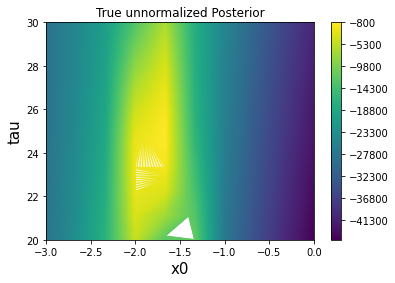

In [ ]:
x0_mesh, tau_mesh = np.meshgrid(x0_range, tau_range)
plt.contour(x0_mesh, tau_mesh, gm_log_prob, levels=1000)
plt.xlabel('x0', fontsize=15)
plt.ylabel('tau', fontsize=15)
plt.colorbar()
plt.title('True unnormalized Posterior')
# find_log_prob([-3.0, tf.math.log(20.0)])

#### Define the variational posterior using Normalizing flows

In [21]:
num_bijectors = 5
tf.random.set_seed(100)
bijectors = []
for i in range(num_bijectors-1):
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[256,256], activation='relu')
    maf = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
    bijectors.append(maf)
    bijectors.append(tfb.Permute(permutation=tf.random.shuffle(tf.range(3*nn+2))))

made = tfb.AutoregressiveNetwork(params=2, hidden_units=[256,256], activation='relu')
maf = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)  
bijectors.append(maf)
chained_maf = tfb.Chain(list(reversed(bijectors)))
base_dist = tfd.Independent(tfd.Normal(loc=tf.zeros(3*nn+2), scale=tf.ones(3*nn+2), name='Base Distribution'),
                            reinterpreted_batch_ndims=1)
flow_dist = tfd.TransformedDistribution(distribution=base_dist, 
                                        bijector=chained_maf,
                                        name='Variational Posterior')

In [ ]:
flow_log_prob = np.zeros((x0_range.size, tau_range.size))
for i, x0_val in enumerate(x0_range):
    for j, tau_val in enumerate(tau_range):
        flow_log_prob[j,i] = flow_dist.log_prob([x0_val, tau_val])

Text(0.5, 1.0, 'Variational Posterior before training')

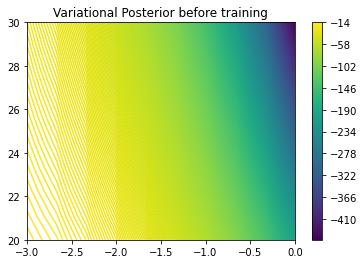

In [ ]:
plt.contour(x0_mesh, tau_mesh, flow_log_prob, levels=1000)
plt.colorbar()
plt.title('Variational Posterior before training')

#### Define functions to compute loss and gradients

In [28]:
@tf.function
def loss(posterior_approx, base_dist_samples, x_obs, SC):
    posterior_samples = posterior_approx.bijector.forward(base_dist_samples)
    # tf.print(posterior_samples)
    # tf.print(posterior_samples)
    nsamples = base_dist_samples.shape[0]
    loss_val = 0.0
    for theta in posterior_samples:
        gm_log_prob = epileptor2D_log_prob(theta, x_obs, SC)
        posterior_approx_log_prob = posterior_approx.log_prob(theta)
        loss_val += (posterior_approx_log_prob - gm_log_prob)/nsamples
        # tf.print("theta: ", theta)
        # tf.print("gm_log_prob:",gm_log_prob, "\t posterior_approx_log_prob:", posterior_approx_log_prob)
        # tf.print("loss_val: ", loss_val)
    return loss_val

# y_init = tf.constant([-2.0, 5.0])
# dt = tf.constant(0.1)
# solution_times = dt * np.arange(0, 300)
# eps = tf.constant(0.1)

@tf.function
def get_loss_and_gradients(posterior_approx, base_dist_samples, x_obs, SC):
    with tf.GradientTape() as tape:
        loss_val = loss(flow_dist, base_dist_samples, x_obs, SC)
        return loss_val, tape.gradient(loss_val, posterior_approx.trainable_variables)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [27]:
@tf.function
def find_log_prob():
    with tf.device('/device:CPU:0'):
        posterior_samples = flow_dist.bijector.forward(base_dist_samples)
        # tf.print(posterior_samples)
        t = tf.map_fn(Epileptor2D_log_prob, posterior_samples, parallel_iterations=5)
    return t

import time
start_time = time.time()
find_log_prob()
print("--- %s seconds ---" % (time.time() - start_time))


--- 56.922733545303345 seconds ---


In [8]:
print(tf.autograph.to_code(get_loss_and_gradients.python_function))

def tf__get_loss_and_gradients(posterior_approx, base_dist_samples):
    with ag__.FunctionScope('get_loss_and_gradients', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        nsamples = ag__.ld(base_dist_samples).shape[0]
        with ag__.ld(tf).GradientTape() as tape:
            posterior_samples = ag__.converted_call(ag__.ld(posterior_approx).bijector.forward, (ag__.ld(base_dist_samples),), None, fscope)
            loss_val = 0.0

            def get_state():
                return (loss_val,)

            def set_state(vars_):
                nonlocal loss_val
                (loss_val,) = vars_

            def loop_body(itr):
                nonlocal loss_val
                theta = itr
                gm_log_prob = ag__.converted_call(ag__.ld(Epileptor2D_log_prob), (ag__.ld(theta), ag__.ld(obs_data)), None, fscope)

In [ ]:
@tf.function
def find_loss():
    loss_val = loss(flow_dist, tf.constant([[-0.29448965, -0.95975673],[ 0.17711619,  0.222046]], dtype=tf.float32))
    return loss_val

# loss_val, grads = get_loss_and_gradients(flow_dist, base_dist_samples)
# print(loss_val)
# print(grads)

# base_dist_samples = tf.constant([[-0.29448965, -0.95975673],[ 0.17711619,  0.222046]], dtype=tf.float32)
# posterior_samples = flow_dist.bijector.forward(base_dist_samples)
# for theta in posterior_samples:
#     gm_log_prob = gm.log_prob(theta)
#     print(gm_log_prob)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [ ]:
print(loss)

tf.Tensor(inf, shape=(), dtype=float32)


In [26]:
batch_size = 10
base_dist_samples = tf.data.Dataset.from_tensor_slices(base_dist.sample((batch_size*500))).batch(batch_size, drop_remainder=True)

In [29]:
num_epochs = 2

training_loss = []
import time
start_time = time.time()

for epoch in range(num_epochs):
    for batch_base_dist_samples in base_dist_samples.as_numpy_iterator():            
        loss_value, grads = get_loss_and_gradients(flow_dist, tf.constant(batch_base_dist_samples, dtype=tf.float32), obs_data['x'], SC)
        tf.print("loss: ", loss_value)
        training_loss.append(loss_value)
        optimizer.apply_gradients(zip([tf.divide(el, batch_size) for el in grads], flow_dist.trainable_variables))
    if ((epoch+1)%10 == 0):
        print(f'Epoch {epoch + 1}:\n Training Loss: {loss_value}')
    print(f"Elapsed: {time.time()-start_time} seconds for {num_epochs} Epochs")

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Text(0.5, 0, 'z_init')

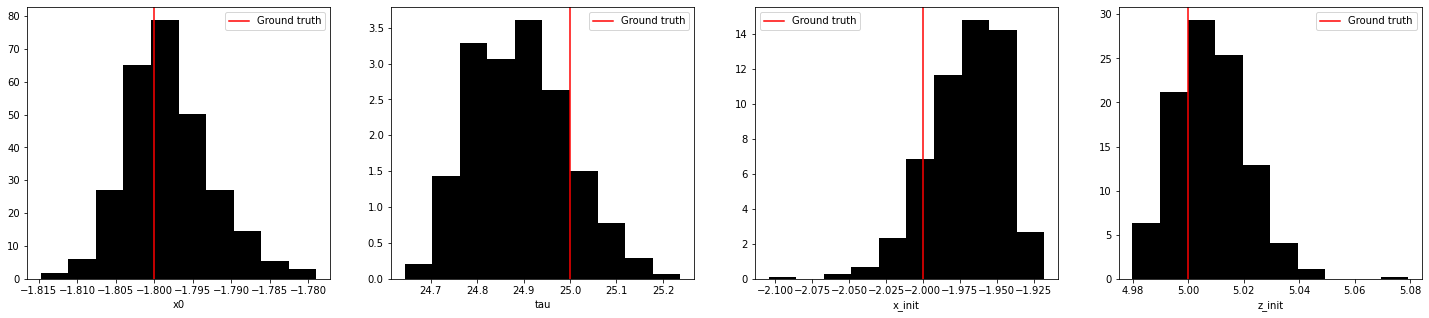

In [68]:
samples = flow_dist.sample((1000))

plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.hist(samples[:,0], density=True, color='black')
plt.axvline(x0_true, color='red', label='Ground truth')
plt.legend()
plt.xlabel('x0')

plt.subplot(1,4,2)
plt.hist(10 + np.exp(samples[:,1]), density=True, color='black')
plt.axvline(tau_true, color='red', label='Ground truth')
plt.legend()
plt.xlabel('tau')

plt.subplot(1,4,3)
plt.hist(samples[:,2], density=True, color='black')
plt.axvline(x_init_true, color='red', label='Ground truth')
plt.legend()

plt.xlabel('x_init')
plt.subplot(1,4,4)
plt.hist(samples[:,3], density=True, color='black')
plt.axvline(z_init_true, color='red', label='Ground truth')
plt.legend()
plt.xlabel('z_init')


In [ ]:
flow_log_prob = np.zeros((b_range.size, m_range.size))
for i, m_val in enumerate(m_range):
    for j, b_val in enumerate(b_range):
        flow_log_prob[j,i] = flow_dist.log_prob([m_val, b_val])

In [ ]:
plt.contour(m_mesh, b_mesh, flow_log_prob, levels=1000)
plt.colorbar()
plt.title('Variational Posterior after training')

In [44]:
x0 = tf.reduce_mean(samples[:,0], axis=0)
tau = tf.reduce_mean(samples[:,1], axis=0)
tau_trans = 10.0 + tf.math.exp(tau)
y_init = tf.reduce_mean(samples[:,2:4], axis=0)
t_init = tf.constant(0.0, dtype=tf.float32)
time_step = tf.constant(0.1, dtype=tf.float32)
solution_times = time_step * tf.range(0, 300, dtype=tf.float32)
y = integrator(epileptor2D_ode_fn, t_init, y_init, solution_times, {'x0':x0, 'tau':tau_trans})

Text(0, 0.5, 'z')

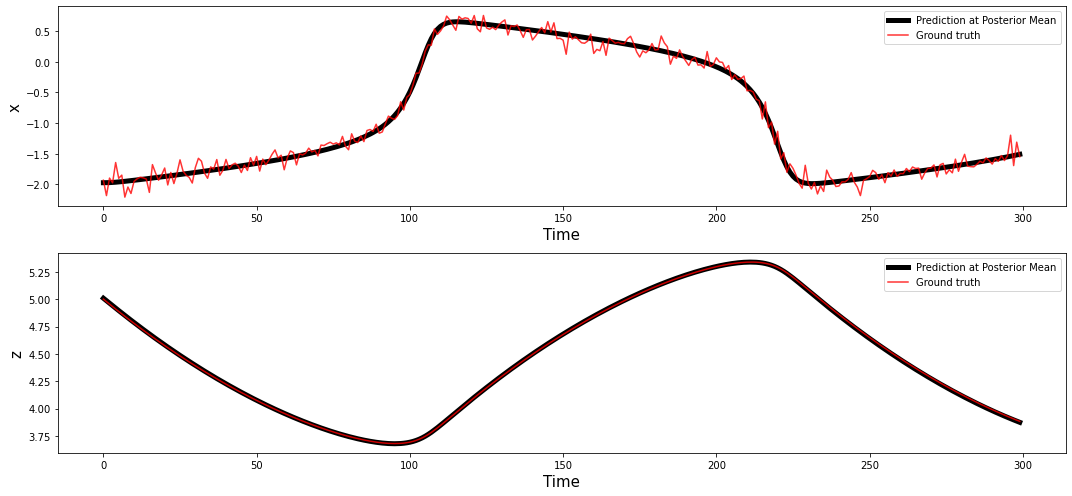

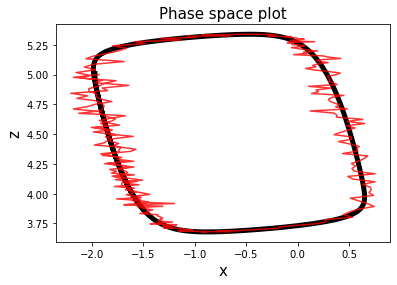

In [62]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(y.states[:,0], label='Prediction at Posterior Mean', lw=5.0, color='black')
plt.plot(obs_data['x'], color='red', label='Ground truth', alpha=0.8)
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.legend()

plt.subplot(2,1,2)
plt.plot(y.states[:,1], label='Prediction at Posterior Mean', lw=5.0, color='black')
plt.plot(obs_data['z'], color='red', label='Ground truth', alpha=0.8)
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.tight_layout()
plt.legend()

plt.figure()
plt.title("Phase space plot", fontsize=15)
plt.plot(y.states[:,0], y.states[:,1], color='black', lw=5.0)
plt.plot(obs_data['x'], obs_data['z'], color='red', alpha=0.8)
plt.xlabel('x', fontsize=15)
plt.ylabel('z', fontsize=15)